In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import operator

plt.figure(figsize=(15,15))

import cv2
import numpy as np

%matplotlib inline

# https://aishack.in/tutorials/sudoku-grabber-opencv-detection/
# https://mc.ai/sudoku-solver-using-opencv-and-dl%E2%80%8A-%E2%80%8Apart-1/

[array([ 54, 147], dtype=int32), array([1442,  148], dtype=int32), array([1441, 1615], dtype=int32), array([  50, 1613], dtype=int32)]
[ 54 147] [1442  148] [1441 1615] [  50 1613]


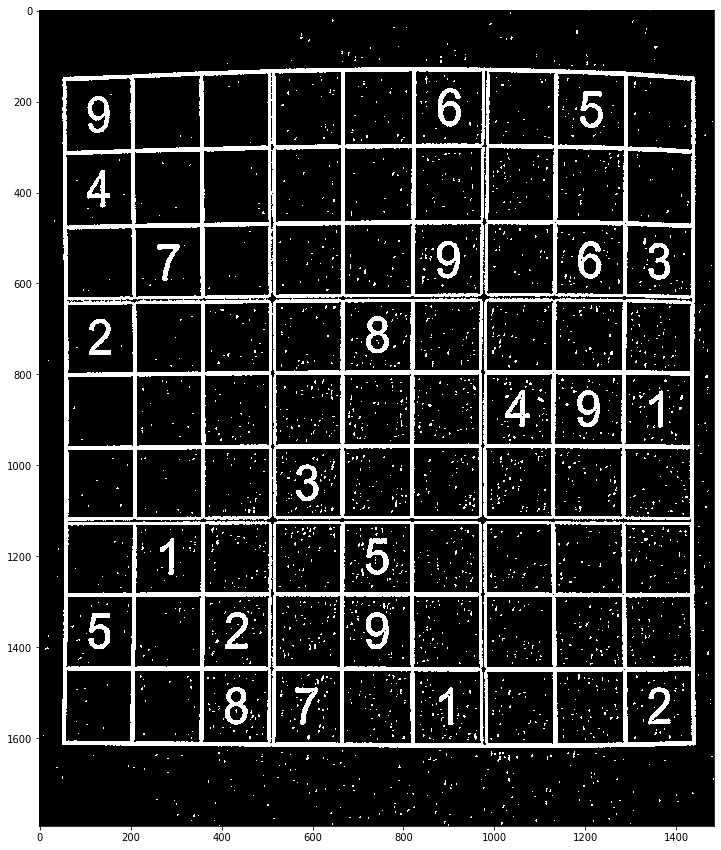

In [47]:
#read image
image = cv2.imread('1.jpg')

#gaussian blur
image = cv2.GaussianBlur(image, (11, 11), 0)

#to gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#adaptiveThreshold(sudoku, outerBox, 255, ADAPTIVE_THRESH_MEAN_C, THRESH_BINARY, 5, 2);
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)

#invert the image outerBox
thresh = cv2.bitwise_not(thresh, thresh)

#sharpening?
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
thresh = cv2.dilate(thresh, kernel)


contours, h = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

#print(polygon)

bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))

print([polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]])

crop_rect=[polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

print(crop_rect[0],crop_rect[1], crop_rect[2], crop_rect[3])

#top-left:[54 147]
#top-right: [50 1613]
#bottom-right: [1441 1615]
#bottom-left: [1442  148]

plt.figure(figsize=(15,15))
plt.imshow(thresh, cmap='gray');

Width:  1391 Height:  1467
Wall time: 13 ms


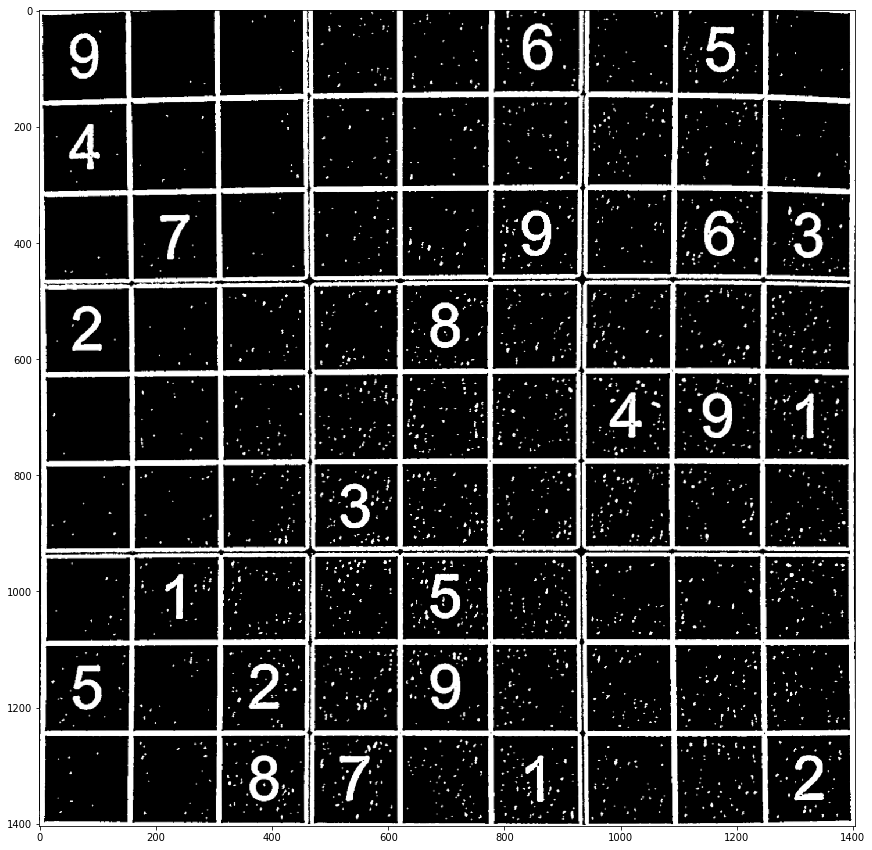

In [48]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    
    print('Width: ', maxWidth, 'Height: ', maxHeight)
    
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    warped_r = cv2.resize(warped, (1404, 1404))
    
    
    
    # return the warped image
    return warped_r


# crop_rect = [[54,147],[1442,148],[1441,1615],[50,1613]]
pts = np.asarray(crop_rect)

%time warped = four_point_transform(thresh, pts)
plt.figure(figsize=(15,15))
plt.imshow(warped, cmap='gray');

In [49]:

squares = [] 
side = warped.shape[:1] 
side = side[0] / 9
for j in range(9):
     for i in range(9):
        p1 = (i * side, j * side) #Top left corner of a box 
        p2 = ((i + 1) * side, (j + 1) * side) #Bottom right corner 
        squares.append((p1, p2)) 
print(squares)



[((0.0, 0.0), (156.0, 156.0)), ((156.0, 0.0), (312.0, 156.0)), ((312.0, 0.0), (468.0, 156.0)), ((468.0, 0.0), (624.0, 156.0)), ((624.0, 0.0), (780.0, 156.0)), ((780.0, 0.0), (936.0, 156.0)), ((936.0, 0.0), (1092.0, 156.0)), ((1092.0, 0.0), (1248.0, 156.0)), ((1248.0, 0.0), (1404.0, 156.0)), ((0.0, 156.0), (156.0, 312.0)), ((156.0, 156.0), (312.0, 312.0)), ((312.0, 156.0), (468.0, 312.0)), ((468.0, 156.0), (624.0, 312.0)), ((624.0, 156.0), (780.0, 312.0)), ((780.0, 156.0), (936.0, 312.0)), ((936.0, 156.0), (1092.0, 312.0)), ((1092.0, 156.0), (1248.0, 312.0)), ((1248.0, 156.0), (1404.0, 312.0)), ((0.0, 312.0), (156.0, 468.0)), ((156.0, 312.0), (312.0, 468.0)), ((312.0, 312.0), (468.0, 468.0)), ((468.0, 312.0), (624.0, 468.0)), ((624.0, 312.0), (780.0, 468.0)), ((780.0, 312.0), (936.0, 468.0)), ((936.0, 312.0), (1092.0, 468.0)), ((1092.0, 312.0), (1248.0, 468.0)), ((1248.0, 312.0), (1404.0, 468.0)), ((0.0, 468.0), (156.0, 624.0)), ((156.0, 468.0), (312.0, 624.0)), ((312.0, 468.0), (468.0,

In [54]:
image = warped.copy()
cropped = image[0:0, 156:156]

#plt.imshow(cropped, cmap='gray');
#cv2.imwrite("thumbnail.png", cropped)

y=0
x=0
h=156
w=156
crop = image[y:y+h, x:x+w]


from PIL import Image
im = Image.fromarray(crop)
im.save("00.jpg")

---

---

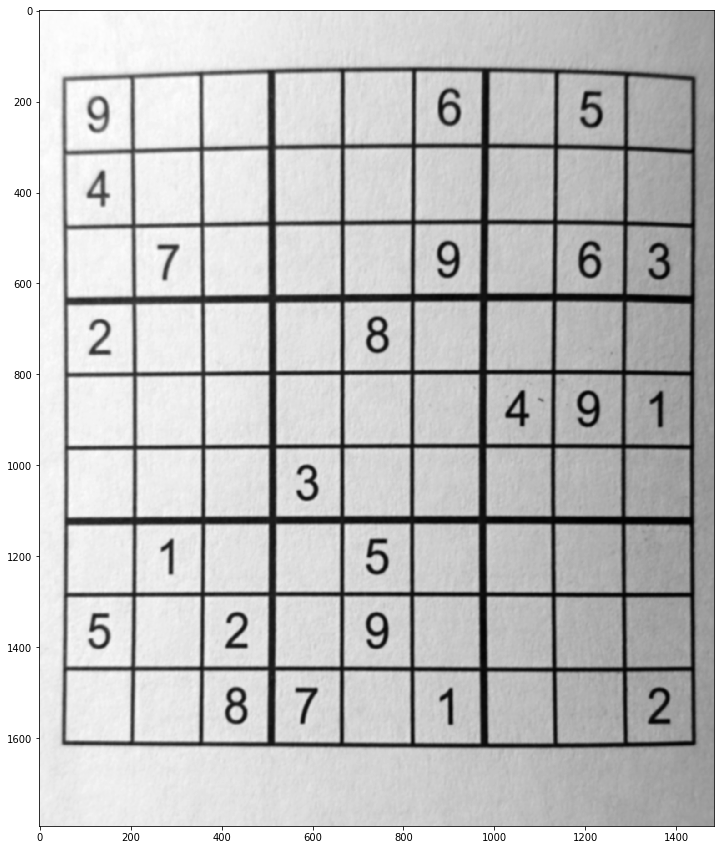

In [18]:
def preprocessImg(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    plt.figure(figsize=(15,15))
    plt.imshow(gray, cmap='gray');
    # gray = cv.GaussianBlur(gray, (11, 11), 0)
    # outerBox = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 2)
    #ret,thresh = cv.threshold(gray,128,255,cv.THRESH_BINARY)
    # cv.imshow('thresh', thresh)
    #outerBox = cv.bitwise_not(thresh)
    #cv.imshow('BitwiseNot', outerBox)
    #return outerBox

image = cv2.imread('1.jpg')
preprocessImg(image)

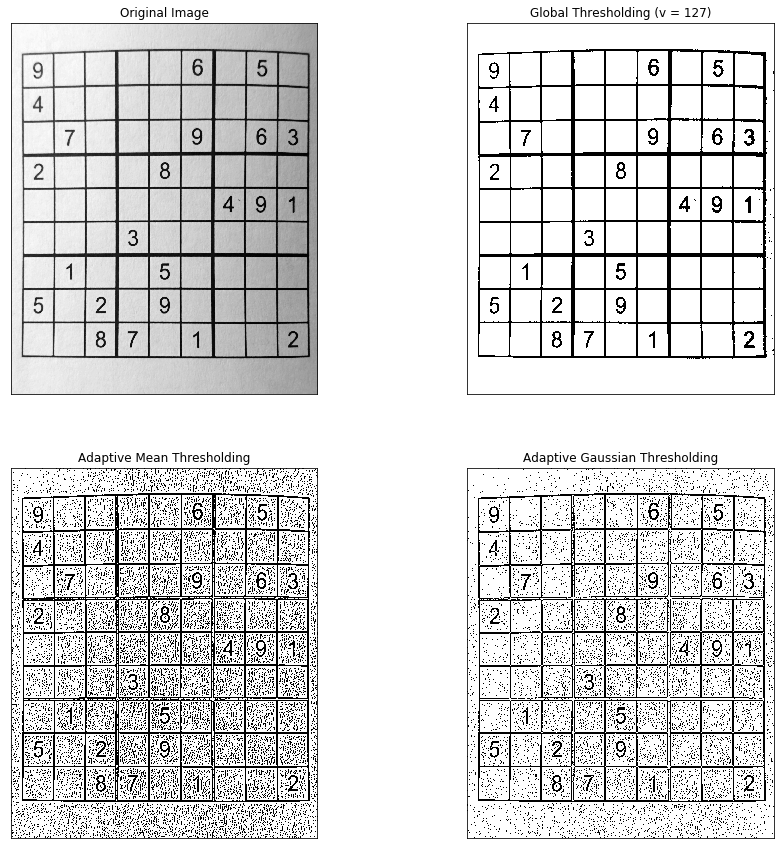

In [23]:
img = cv2.imread('1.jpg',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,130,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

plt.figure(figsize=(15,15))

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()